In [1]:
import os
import pymysql
import pandas as pd

host = '127.0.0.1'
port = "3306"
user = 'root'
password = ''
database = 'news'

conn = pymysql.connect(
    host=host,
    port=int(port),
    user=user,
    passwd=password,
    db=database,
    charset='utf8mb4')

def run(sql):
    df = pd.read_sql_query(sql,conn)
    return df

Mengekstrak row yang hanya memuat keyword yang kita inginkan. Jangan lupa membaca komentar program, untuk mengganti tanggal yang mau diekstrak.

In [2]:
label0 = "Global Warming"
label1 = "Penyebab Alami"
label2 = "Perubahan Iklim"
label3 = "Mitigasi"
label4 = "Penyakit"

jumlahlabel = 5

# ganti keyword di sini
keyword0 = "pollution", "deforestation", "greenhouse", "plastic waste", "ilegal logging", "carbon dioxide", "methane", "emission", "emissions", "global warming" #sebab
keyword1 = "volcanic eruptions", "volcanic eruption", "volcano eruption", "eruption", "volcano eruptions" #sebab dr alam
keyword2 = "flood damage", "flood damages", "extreme drought", "climate change", "climate changes", "desertification", "extreme weather" #akibat
keyword3 = "alternative energy", "renewable energy", "energy efficiency", "greening", "reforestation", "greenpeace", "eco-", "waste reduction", "sustainability", "sustainable development", "sustainable developments", "renewable resource", "renewable resources", "kyoto protocol" #mitigasi
keyword4 = "epidemic", "endemic", "disease", "virus", "dengue fever", "mumps", "zika", "mosquito-borne", "contaminated water", "influenza" #penyakit

# gabungan keyword
keyword = tuple(j for i in (keyword0, keyword1, keyword2, keyword3, keyword4) for j in (i if isinstance(i, tuple) else (i,)))

for i in range(jumlahlabel):
    if eval("isinstance(keyword{0}, str)".format(i)):
        exec("query{0} = \"SELECT * FROM gdelt WHERE content LIKE '%%%s%%'\" %keyword{0}".format(i))
    else:
        exec("query{0} = \"SELECT * FROM gdelt WHERE content LIKE '%%%s%%'\" %(keyword{0}[0]) + \" OR content LIKE '%%%s%%'\"*(len(keyword{0})-1) %(keyword{0}[1:])".format(i))
    
    exec("master{0} = run(query{0})".format(i))
    
    #Ganti 201806 di bawah dengan bulan dan tahun yang akan diteliti. Misal, Agustus 2018 jadi '201808'
    exec("master{0} = master{0}.loc[master{0}[\"MonthYear\"]=='201807']".format(i))
    exec("master{0}['AvgTone'] = master{0}['AvgTone'].apply(float)".format(i))
    exec("master{0}['NumArticles'] = master{0}['NumArticles'].apply(int)".format(i))
    # mengubah tipe data kolom "SQLDATE" menjadi tipe data "datetime"
    exec("master{0}['SQLDATE'] = pd.to_datetime(master{0}['SQLDATE'])".format(i))

In [3]:
# Contoh hasil (hanya ditunjukkan 3 teratas)
master0.head()

,GLOBALEVENTID,SQLDATE,MonthYear,Year,FractionDate,Actor1Code,Actor1Name,Actor1CountryCode,Actor1KnownGroupCode,Actor1EthnicCode,...,ActionGeo_FullName,ActionGeo_CountryCode,ActionGeo_ADM1Code,ActionGeo_Lat,ActionGeo_Long,ActionGeo_FeatureID,DATEADDED,SOURCEURL,title,content
0,768595790,2018-07-01,201807,2018,2018.4959,None,None,None,None,None,...,"Sepang, Sumatera Barat, Indonesia",ID,ID24,0.0577,100.754,10121875,20180701,https://www.theonlinecitizen.com/2018/07/01/ma...,"Mahathir, Jokowi discuss possibility of a join...","Earlier on 28 June, Prime Minister Tun Dr Maha..."
1,768595791,2018-07-01,201807,2018,2018.4959,None,None,None,None,None,...,"Jakarta, Jakarta Raya, Indonesia",ID,ID04,-6.17444,106.829,-2679652,20180701,https://www.theonlinecitizen.com/2018/07/01/ma...,"Mahathir, Jokowi discuss possibility of a join...","Earlier on 28 June, Prime Minister Tun Dr Maha..."
2,768595792,2018-07-01,201807,2018,2018.4959,None,None,None,None,None,...,"Halim Perdanakusuma, Jakarta Raya, Indonesia",ID,ID04,-6.2647,106.894,10169008,20180701,https://www.theonlinecitizen.com/2018/07/01/ma...,"Mahathir, Jokowi discuss possibility of a join...","Earlier on 28 June, Prime Minister Tun Dr Maha..."
3,768595793,2018-07-01,201807,2018,2018.4959,None,None,None,None,None,...,"Sepang, Sumatera Barat, Indonesia",ID,ID24,0.0577,100.754,10121875,20180701,https://www.theonlinecitizen.com/2018/07/01/ma...,"Mahathir, Jokowi discuss possibility of a join...","Earlier on 28 June, Prime Minister Tun Dr Maha..."
4,768596152,2018-07-01,201807,2018,2018.4959,GOV,PRESIDENT,None,None,None,...,"Sepang, Sumatera Barat, Indonesia",ID,ID24,0.0577,100.754,10121875,20180701,https://www.theonlinecitizen.com/2018/07/01/ma...,"Mahathir, Jokowi discuss possibility of a join...","Earlier on 28 June, Prime Minister Tun Dr Maha..."


In [4]:
def satukandf(string):
    # List berisi seluruh dataframe sebelum disatukan menjadi satu dataframe
    daftar = [eval(string+"{0}".format(i)) for i in range(jumlahlabel)]

    # menggabungkan semua dataframe, mengisi cell berisi "NaN" dengan 0, dan mereset indeks (karena indeks sebelumnya ada di kolom SQLDATE)
    tabel = pd.concat(daftar, axis=1, sort=True).fillna(0).reset_index()

    # mengganti nama kolom berisi tanggal menjadi "tanggal"
    tabel.columns.values[0] = 'Tanggal'

    # Contoh hasil (ditunjukkan 6 teratas)
    return tabel

In [5]:
# Drop duplicate dan menyimpan hanya di pertama kali pemberitaan muncul

for i in range(jumlahlabel):
    exec("master{0}=master{0}.drop_duplicates(['SOURCEURL'],keep='first')".format(i))

In [6]:
# Mengelompokkan Jumlah Artikel per Bulan per Label

for i in range(jumlahlabel):
    # Mengelompokkan berdasar tanggal dan menghitung jumlah distinct (unique) pemberitaan dengan 'nunique()'
    exec("artikel{0} = master{0}[['NumArticles','SQLDATE']].groupby(['SQLDATE']).sum()".format(i))

In [25]:
# Cek pemberitaan terbanyak di tanggal 1 Juli itu tentang apa
master1.loc[master1['SQLDATE']=='2018-07-03', ['NumArticles','SQLDATE','content']]

,NumArticles,SQLDATE,content
42,8,2018-07-03,A volcano on the Indonesian island of Bali has...
46,8,2018-07-03,A volcano on the popular tourist spot of Bali ...
47,3,2018-07-03,The Mount Agung volcano on the Indonesian tour...
49,10,2018-07-03,"Mount Agung volcano erupts in Bali, Indonesia,..."
50,10,2018-07-03,The Indonesian geological agency’s Agung monit...
53,20,2018-07-03,Fire is seen on the slopes of Mount Agung volc...
55,20,2018-07-03,"Mount Agung volcano erupts as seen from Kubu, ..."
56,3,2018-07-03,An eruption at Mount Agung volcano on the Indo...
57,45,2018-07-03,An eruption at Mount Agung volcano on the Indo...
59,9,2018-07-03,Mount Agung strikes again\n\nMount Agung on Mo...


In [8]:
#assign ke variabel
eksposur = satukandf("artikel")

In [9]:
#show result
eksposur.head(6)

,Tanggal,NumArticles,NumArticles,NumArticles,NumArticles,NumArticles
0,2018-07-01,11,10.0,9.0,38,26.0
1,2018-07-02,67,99.0,58.0,46,112.0
2,2018-07-03,62,160.0,25.0,56,89.0
3,2018-07-04,47,75.0,15.0,63,193.0
4,2018-07-05,104,0.0,28.0,70,20.0
5,2018-07-06,59,1.0,19.0,55,24.0


In [10]:
# Menghitung Rata-rata Tonasi Pemberitaan per Label

for i in range(jumlahlabel):
    exec("tonasi{0} = master{0}[['SQLDATE','AvgTone']].groupby('SQLDATE').mean()".format(i))
    exec("tonasi{0}.columns = ['Mean Tonasi Label {0}']".format(i))

In [11]:
#assign ke variabel
tonasi = satukandf("tonasi")

In [12]:
# Contoh hasil (ditunjukkan 6 teratas)
tonasi.head()

,Tanggal,Mean Tonasi Label 0,Mean Tonasi Label 1,Mean Tonasi Label 2,Mean Tonasi Label 3,Mean Tonasi Label 4
0,2018-07-01,-1.878691,-3.078206,-2.679064,0.615577,-3.480015
1,2018-07-02,-0.974388,-5.094843,-1.053283,-1.425645,-5.498530
2,2018-07-03,-1.440275,-5.546066,-2.615456,-1.726039,-4.621914
3,2018-07-04,-2.954412,-5.759649,0.390438,-0.851182,-4.548759
4,2018-07-05,-2.415002,0.000000,-1.239659,-0.747404,-4.169270


In [13]:
# Menghitung jumlah berita dalam masing-masing kategori

for i in range(jumlahlabel):
    # Mengelompokkan berdasar tanggal dan menghitung jumlah distinct (unique) pemberitaan dengan 'nunique()'
    exec("kode{0} = master{0}[['EventRootCode','SQLDATE']].groupby(['EventRootCode']).count()".format(i))
    # Mengubah nama kolom agar dataframe nanti bisa terbaca
    exec("kode{0}.columns = ['CAMEO Code {0}']".format(i))

In [14]:
#assign ke variabel
kode = satukandf("kode")
kode.columns.values[0] = 'Kode'

In [15]:
# Contoh hasil (ditunjukkan 5 teratas)
kode.head(5)

,Kode,CAMEO Code 0,CAMEO Code 1,CAMEO Code 2,CAMEO Code 3,CAMEO Code 4
0,01,43.0,10.0,15.0,41.0,30.0
1,02,22.0,6.0,10.0,23.0,8.0
2,03,14.0,4.0,8.0,15.0,13.0
3,04,42.0,29.0,19.0,59.0,26.0
4,05,13.0,2.0,8.0,21.0,6.0


---

In [16]:
# Mengelompokkan Quad Class per Bulan per Data

for i in range(jumlahlabel):
    # Mengelompokkan berdasar tanggal dan menghitung jumlah distinct (unique) pemberitaan dengan 'nunique()'
    exec("quad{0} = master{0}[['QuadClass','content']].groupby(['QuadClass']).count()".format(i))
    # Mengubah nama kolom agar dataframe nanti bisa terbaca
    exec("quad{0}.columns = ['Quad Class {0}']".format(i))

In [17]:
#assign ke variabel
quad = satukandf("quad")

In [18]:
# Contoh hasil
quad

,Tanggal,Quad Class 0,Quad Class 1,Quad Class 2,Quad Class 3,Quad Class 4
0,1,134,51,60,159,83
1,2,55,19,18,44,19
2,3,17,2,14,20,17
3,4,19,22,11,15,24


Membuat plotting Quad Class per Bulan

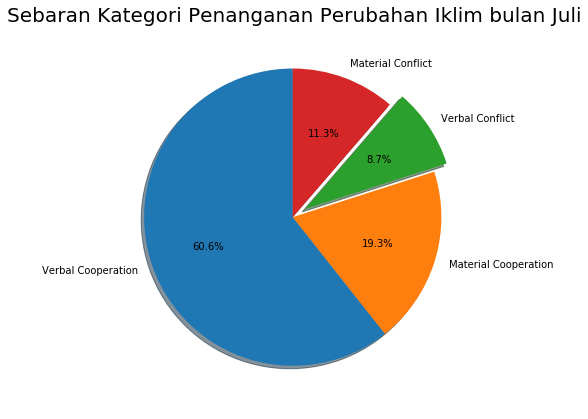

In [20]:
import matplotlib.pyplot as plt

total = 0

for i in range(jumlahlabel):
    total += sum(quad['Quad Class {0}'.format(i)])
    # ukuran pie
    exec("sizes{0} = [quad['Quad Class {0}'][j]/sum(quad['Quad Class {0}'])*100 for j in range(4)]".format(i))

# label dari chart

sizes = [sum(quad.loc[i][1:])/total*100 for i in range(4)]
labels = 'Verbal Cooperation', 'Material Cooperation', 'Verbal Conflict', 'Material Conflict'
# ukuran masing-masing
explode = (0, 0, 0.1, 0)  # only "explode" the 3rd slice

fig, ax = plt.subplots()
fig.set_figheight(7)
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax.axis('equal')
ax.set_title("Sebaran Kategori Penanganan Perubahan Iklim bulan Juli", fontsize=20)

plt.show()

In [21]:
# Save Gambar Plot
fig.savefig('Juli4.jpg')

In [22]:
# Membuat file excel dari output dataframe di atas
# Ganti nama file "outputJuni" menjadi output bulan masing-masing
writer = pd.ExcelWriter('outputJuli.xlsx')

# Memasukkan DataFrame ke Excel
eksposur.to_excel(writer, sheet_name='Eksposur', index=False)
tonasi.to_excel(writer, sheet_name='Tonasi', index=False)
kode.to_excel(writer, sheet_name='Cameo Code', index=False)

# Menyimpan file
writer.save()

---

In [79]:
# Menghitung Rata-rata Goldstein Scale per Label per 

# for i in range(jumlahlabel):
#     exec("tonasi{0} = master{0}[['SQLDATE','AvgTone']].groupby('SQLDATE').mean()".format(i))
#     exec("tonasi{0}.columns = ['Mean Tonasi Label {0}']".format(i))



CADANGAN
---

In [23]:
# Menghitung Jumlah pemberitaan di GDELT Data

for i in range(jumlahlabel):
    # Mengelompokkan berdasar tanggal dan menghitung jumlah distinct (unique) pemberitaan dengan 'nunique()'
    exec("eksposur{0} = master{0}[['SQLDATE','content']].groupby('SQLDATE').nunique()[['content']]".format(i))
    # Mengubah nama kolom agar dataframe nanti bisa terbaca
    exec("eksposur{0}.columns = ['Jumlah Berita Label {0}']".format(i))

# Contoh hasil (ditunjukkan hanya 5 terawal)
eksposur0.head()

,Jumlah Berita Label 0
SQLDATE,
2018-07-01,3
2018-07-02,8
2018-07-03,8
2018-07-04,10
2018-07-05,13


TypeError: cannot label index with a null key

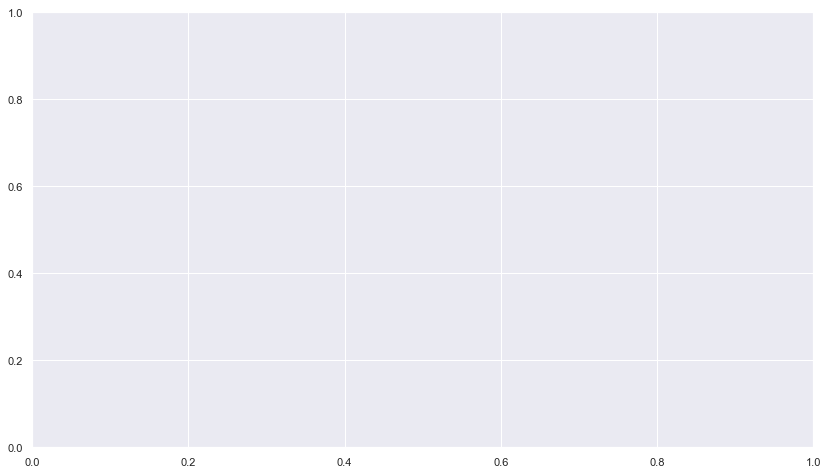

In [24]:
# Untuk plotting ketika semua data sudah disatukan

import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(14,8))

y = ["Jumlah Berita Label {0}".format(i) for i in range(jumlahlabel)]

for i in range(0,5):
    sns.lineplot(x="Indeks", y="Jumlah Berita Label {0}".format(i), data=eksposur, ax=ax, label=eval("label{0}".format(i)))
ax.legend()
plt.show()